## Cross-Platform Latent Connectivity Detection using the Temporal Dimension

### Social Media Usecase

Not all connections between individuals are apparent in the structural network data we have access to. One example to such scenario is when individuals employ different platforms of communications, which inherently lack inter-platform connections.

In this demo, we demonstrate the ability to detect communities whose members act on separate platforms, despite the absence of explicit connections between them.
We introduce the concept of an individual's temporal fingerprint, defined by the time gaps between consecutive activities (inter-event time distribution), and find that community members present similar temporal fingerprints. 

This methodology uses merely the temporal metadata of users' activity, and does not require access to network structure or user generated content. As such, it can be employed on any type of temporal dataset, including encrypted domains.

**Overview**
1. Loading the data
2. Preprocessing (Building the Connections)
3. Visualizations
4. Evaluation & Benchmarking

**Files:**
1. posts_identity_matching_masked_v2.csv: raw metadata of posting activity (see Section 1: Loading the data)


**Data Labeling**

We label a group of profiles as belonging to the same community if their profile names, biographies, or public activity clearly indicate they belong to, represent, or work under the same organization.

The matching process included surfacing pairs of profiles - typically organizations - with very similar names, and affirming their relationship manually by reviewing their respective profiles. Additionally, we searched for and included affilliates and subsidiaries of organizations, which we found via biographical information, although those account for a small portion of the data.

Examples of communities:
1. [(@company1, twitter), (@company1, telegram)]
2. [(@company2_worker1, instagram), (@company2_worker2, telegram), (@company2_worker3, twitter)]

**Data Disclaimer**

The data was provided by a third party and carefully tagged using the guidelines above.

**Citation**

If you find our work useful, please kindly consider citing the original paper: https://arxiv.org/pdf/2407.04350

### Loading the Data

The dataset includes posting activity metadata collected over the span of 18 days from various social media platforms such as twitter (X), telegram, and instagram. The schema:
- "creator_name" (string): encryped name of the profile that posted 
- "platform_type" (string): the social platform to which the profile belongs
- "creation_time" (string): the date and time at which the post was created, in the format of %Y-%m-%d %H:%M:%S

*Note: a 'user' is defined as a unique pair of "creator_name" and "platform_type".*

In [46]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import normalized_mutual_info_score

from typing import Iterable, Tuple, List

In [47]:
# load the post metadata
posts_df = pd.read_csv("posts_identity_matching_masked_v2.csv", index_col=0)

# let's look at the first week
posts_df = posts_df[posts_df["creation_time"].between("2024-06-08", "2024-06-15")]

# save column names as constants
PROFILE_COL_NAME, PLATFORMS_COL_NAME, CREATION_TIMES_COL_NAME, LABEL_COL = posts_df.columns

posts_df.head()

,creator_name,platform_type,creation_time,label
2,5389646ea08918451bdc1763a116fe00b1f1f19e32ea18...,twitter,2024-06-12 04:01:19,1
3,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,2024-06-12 10:19:15,0
7,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,twitter,2024-06-13 14:26:04,7
9,cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a2...,telegram,2024-06-08 12:38:33,10
10,48b8e55428ffcd743a5ed414af8fc20035b84f9180cce2...,telegram,2024-06-10 13:12:34,3


### Preprocessing (Building the Connections)

To extract communities from the data, we'll first need to establish and evaluate the relationship between each pair of users.

This step will include:
1. Computing the *silence periods* between users' consecutive activities, as well as another benchmark representation of their activity
2. Grouping all the information per user
2. Estimating the similarity between every pair of users given their activity, defined as the Kolmogorov-Smirnov distance between their silence periods vectors.


In [48]:
# First, let's convert the string timestamps into datetime
posts_df[CREATION_TIMES_COL_NAME] = pd.to_datetime(posts_df[CREATION_TIMES_COL_NAME])


#### Computing Silence Periods

A silence period is the period of time that elapsed between two consecutive events. In our case, we will define it as the time, in seconds, between two consecutive posts by the same user.

*(Note: Since we later plot the silence period distributions on a log-log scale, we add a precautionary 1 second to all silence periods to avoid a log(0) value)*

In [49]:
# sort posting times per user
posts_df = posts_df.sort_values([PROFILE_COL_NAME, PLATFORMS_COL_NAME, CREATION_TIMES_COL_NAME])
posts_df.head()

,creator_name,platform_type,creation_time,label
66038,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:26:59,0
22304,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:28:35,0
45264,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:30:12,0
97585,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:30:57,0
84292,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:31:48,0


In [50]:
# We'll use as a benchmark a numeric representation of the creation time of the post,
# relative to the earliest posting time in the cohort

min_time = posts_df[CREATION_TIMES_COL_NAME].min()
posts_df["time_from_start"] = (posts_df[CREATION_TIMES_COL_NAME] - min_time).dt.seconds
posts_df.head()

,creator_name,platform_type,creation_time,label,time_from_start
66038,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:26:59,0,4915
22304,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:28:35,0,5011
45264,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:30:12,0,5108
97585,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:30:57,0,5153
84292,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:31:48,0,5204


In [51]:
# Compute the silence periods per user
posts_df['silence_period'] = posts_df.groupby([PROFILE_COL_NAME, PLATFORMS_COL_NAME])[CREATION_TIMES_COL_NAME].diff().dt.seconds.add(1)
posts_df.head()

,creator_name,platform_type,creation_time,label,time_from_start,silence_period
66038,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:26:59,0,4915,NaN
22304,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:28:35,0,5011,97.0
45264,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:30:12,0,5108,98.0
97585,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:30:57,0,5153,46.0
84292,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,2024-06-08 03:31:48,0,5204,52.0


In [52]:
# Aggregate information per user.
from pandas.core.groupby import DataFrameGroupBy

def agg_per_user(user_data: DataFrameGroupBy) -> pd.Series:
    """Aggregates information per user"""
    silence_periods = user_data['silence_period'].dropna().tolist()
    creation_times = user_data[CREATION_TIMES_COL_NAME].tolist()
    time_from_start = user_data['time_from_start'].tolist()
    label = user_data[LABEL_COL].tolist()[0]
    return pd.Series([creation_times, silence_periods, time_from_start, label])

grouped_df = posts_df.groupby([PROFILE_COL_NAME, PLATFORMS_COL_NAME]).apply(agg_per_user)
grouped_df.columns = ["creation_times", "silence_periods", "time_from_start", "label"]
grouped_df.head()

/var/folders/zc/b62gpf_j6_xfkbm72shby5gm0000gn/T/ipykernel_92877/2856280598.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = posts_df.groupby([PROFILE_COL_NAME, PLATFORMS_COL_NAME]).apply(agg_per_user)


creation_times  \
creator_name                                       platform_type                                                      
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter        [2024-06-08 03:26:59, 2024-06-08 03:28:35, 202...   
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter        [2024-06-08 05:19:39, 2024-06-08 06:00:18, 202...   
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram       [2024-06-08 03:52:00, 2024-06-08 03:58:53, 202...   
                                                   twitter        [2024-06-08 05:19:39, 2024-06-08 05:21:16, 202...   
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram       [2024-06-08 02:11:32, 2024-06-08 02:26:41, 202...   

                                                                                                    silence_periods  \
creator_name                                       platform_type                                                      
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter        [97.0, 98.0, 46.0, 52.0, 120.0, 80.0, 316.0, 6...   
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter        [2440.0, 16192.0, 18590.0, 635.0, 1549.0, 1822...   
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram       [414.0, 1910.0, 2895.0, 1428.0, 5594.0, 640.0,...   
                                                   twitter        [98.0, 721.0, 1623.0, 5478.0, 2301.0, 390.0, 1...   
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram       [910.0, 899.0, 588.0, 55.0, 36.0, 855.0, 1104....   

                                                                                                    time_from_start  \
creator_name                                       platform_type                                                      
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter        [4915, 5011, 5108, 5153, 5204, 5323, 5402, 571...   
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter        [11675, 14114, 30305, 48894, 49528, 51076, 528...   
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram       [6416, 6829, 8738, 11632, 13059, 18652, 19291,...   
                                                   twitter        [11675, 11772, 12492, 14114, 19591, 21891, 222...   
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram       [388, 1297, 2195, 2782, 2836, 2871, 3725, 4828...   

                                                                  label  
creator_name                                       platform_type         
01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd... twitter            0  
06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e740... twitter            8  
091dd46487eb1852205ccb85e692aee074fcb9b6cdcb393... telegram           8  
                                                   twitter            8  
0e905501ddd06938daa337f1fef611c5d20f9c4961a38a9... telegram          12

In [53]:
# Filter users based on minimum activity
MINIMUM_ACTIVITY = 20
grouped_df = grouped_df[grouped_df["creation_times"].apply(len) >= MINIMUM_ACTIVITY]

#### Computing the KS (Kolmogorov–Smirnov) distance

The [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) is a nonparametric test for determining whether two samples of data came from the same distribution, or in the other words, the likelihood of observing the two samples of data given that they were drawn from the same probability distribution.

The outcome (statistic) of the test is the maximum distance per value observed between the two provided empirical distributions:

<img src="ks-statistic-illustration.png" alt="KS statistic illustration" style="width: 200px;"/>

We will employ this test to evaluate the similarity between the inter-event time distributions of every pair of users, where lower KS values indicate closer distributions. Our hypothesis is that community members will have similar inter-event time distributions.

*Note: for large datasets, we recommend using a parallelized framework like Spark instead of pandas*

In [54]:
# Compute the KS distance for every pair of users, skipping symmetrical and self comparisons
N = len(grouped_df)
ks_results = []

for i in range(N-1):
    for j in range(i+1, N):
        user1 = grouped_df.iloc[i]
        user2 = grouped_df.iloc[j]
        sp1 = user1.silence_periods
        sp2 = user2.silence_periods
        
        ks, p_val = ks_2samp(sp1, sp2)
        ks_results.append((*user1.name, *user2.name, float(ks), float(p_val)))

ks_results = pd.DataFrame(
    ks_results,
    columns=[
        PROFILE_COL_NAME + "_1",
        PLATFORMS_COL_NAME + "_1",
        PROFILE_COL_NAME + "_2",
        PLATFORMS_COL_NAME + "_2",
        "statistic",
        "p_val"
    ]
)
ks_results.head(5)

,creator_name_1,platform_type_1,creator_name_2,platform_type_2,statistic,p_val
0,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,06cc0863f27cff52aef1e0e084c55bdc91cf6d3ee99e74...,twitter,0.854404,5.522839e-39
1,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,091dd46487eb1852205ccb85e692aee074fcb9b6cdcb39...,telegram,0.592443,6.297080e-62
2,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,091dd46487eb1852205ccb85e692aee074fcb9b6cdcb39...,twitter,0.826309,2.242558e-124
3,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,0e905501ddd06938daa337f1fef611c5d20f9c4961a38a...,telegram,0.366883,4.691081e-62
4,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,telegram,0.153174,2.044515e-13


In [55]:
ks_results.sort_values('statistic')

,creator_name_1,platform_type_1,creator_name_2,platform_type_2,statistic,p_val
351,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.007013,1.000000e+00
9,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,0.016692,9.530948e-01
36,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.017361,9.408320e-01
175,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,telegram,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,twitter,0.024202,9.351088e-01
471,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.034309,2.276064e-01
...,...,...,...,...,...,...
461,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,c677237cedd54f37e261f59f3c6a55608f227b61348821...,twitter,0.878327,3.338150e-95
26,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,c677237cedd54f37e261f59f3c6a55608f227b61348821...,twitter,0.878334,4.219291e-95
128,091dd46487eb1852205ccb85e692aee074fcb9b6cdcb39...,twitter,b88a62af2a90360538840b46d759e122d306bb051b9d87...,telegram,0.878428,1.395376e-154
439,5389646ea08918451bdc1763a116fe00b1f1f19e32ea18...,twitter,c677237cedd54f37e261f59f3c6a55608f227b61348821...,twitter,0.889618,5.102526e-102


### Analysis & Evaluation

Now that we have computed the KS-distance for every pair of users, we will use it to determine communities among users.

**Filtering**

First, we want to get rid of "weak" connections and only keep strongly-connected pairs of users. 

Matching the threshold from the original paper (https://arxiv.org/pdf/2407.04350), we will use an upper bound of 0.05 to define a strong connection.

In [56]:
KS_THRESHOLD = 0.05
ks_preds = ks_results[ks_results["statistic"] <= KS_THRESHOLD]

Now, we want to transform the KS statistic to capture the reversed nature of it (the smaller - the better), and build a graph with the users as nodes and the transformed KS as weighted edges between nodes.

Given the nature of the KS distance, we'll simply transform it to its reciprocal, adding a small positive epislon to avoid zero division:

$$ks \in [0,1]$$
$$ks_{transformed} = \frac{1}{ks + \epsilon} \in (1, 1/\epsilon] \text{ for a small } 0 < \epsilon < 1$$


In [57]:
# transform the KS distance 
def transform_ks(ks_col: pd.Series):
    epsilon = 1e-5
    return 1 / (ks_col + epsilon)

ks_preds["transformed_ks"] = transform_ks(ks_preds["statistic"])
ks_preds

/var/folders/zc/b62gpf_j6_xfkbm72shby5gm0000gn/T/ipykernel_92877/3033458877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ks_preds["transformed_ks"] = transform_ks(ks_preds["statistic"])


,creator_name_1,platform_type_1,creator_name_2,platform_type_2,statistic,p_val,transformed_ks
9,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,0.016692,0.953095,59.871760
14,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,0.038672,0.121531,25.851593
36,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.017361,0.940832,57.568725
175,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,telegram,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,twitter,0.024202,0.935109,41.302610
329,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,0.039001,0.114993,25.633498
345,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,d688c15b16c89a5f89783fbb4f8cd95d4e46be67e46a17...,twitter,0.048861,0.036639,20.461877
351,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.007013,1.000000,142.394405
471,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.034309,0.227606,29.138369
644,c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a81872...,telegram,e7430e901370dfe1261df560c6a25570a228eeeb7df067...,twitter,0.037867,0.932710,26.401363
660,cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a2...,telegram,d688c15b16c89a5f89783fbb4f8cd95d4e46be67e46a17...,twitter,0.044956,0.074516,22.239138


In [58]:
# Create a graph where the users are nodes and the weighted edges are the normalized KS
def create_graph_from_data(data: pd.DataFrame, weight_col: str) -> nx.Graph:
    """
    Builds a weighted graph from pair-based data. The function assumes the dataframe has the columns: 
        - "creator_name_1"
        - "platform_type_1
        - "creator_name_2"
        - "platform_type_2"
        - [weight column]
    
    """
    G = nx.Graph()
    G.add_weighted_edges_from(
        [
            (
                (row[PROFILE_COL_NAME + "_1"], row[PLATFORMS_COL_NAME + "_1"]),
                (row[PROFILE_COL_NAME + "_2"], row[PLATFORMS_COL_NAME + "_2"]),
                row[weight_col],
            )
            for _, row in data.iterrows()
        ]
    )
    return G


G_ks = create_graph_from_data(ks_preds, "transformed_ks")
# Extract commmunities using the louvain algorithm
ks_communities = nx.community.louvain_communities(G_ks)

ks_communities

[{('01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd26dba91e4f2bdbdb4',
   'twitter'),
  ('4266703c597aba236d63a369c11638b36c134cced513ffd2c60930a6e9e66bef',
   'twitter'),
  ('5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bcaf0b14263456f5463fc',
   'telegram'),
  ('fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3e049e92907a88e7ad9',
   'twitter')},
 {('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'telegram'),
  ('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'twitter')},
 {('c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a81872909c3b35f2b2827dd8',
   'telegram'),
  ('e7430e901370dfe1261df560c6a25570a228eeeb7df0670082aab87fabe61ffe',
   'twitter')},
 {('cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a27d7c9474cf730a356a',
   'telegram'),
  ('d688c15b16c89a5f89783fbb4f8cd95d4e46be67e46a17af6ac55f14eca3198a',
   'twitter'),
  ('eb5b6b5313be4c22e7ecc2c1a87f55d40b803c2a6548a7030089b37b04b1df6c',
   'telegram')}]

### Visualizations of Results

/var/folders/zc/b62gpf_j6_xfkbm72shby5gm0000gn/T/ipykernel_92877/275274409.py:20: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.step(sorted_data, cdf, color=color, marker=marker, markersize=5, alpha=0.5, label=label)


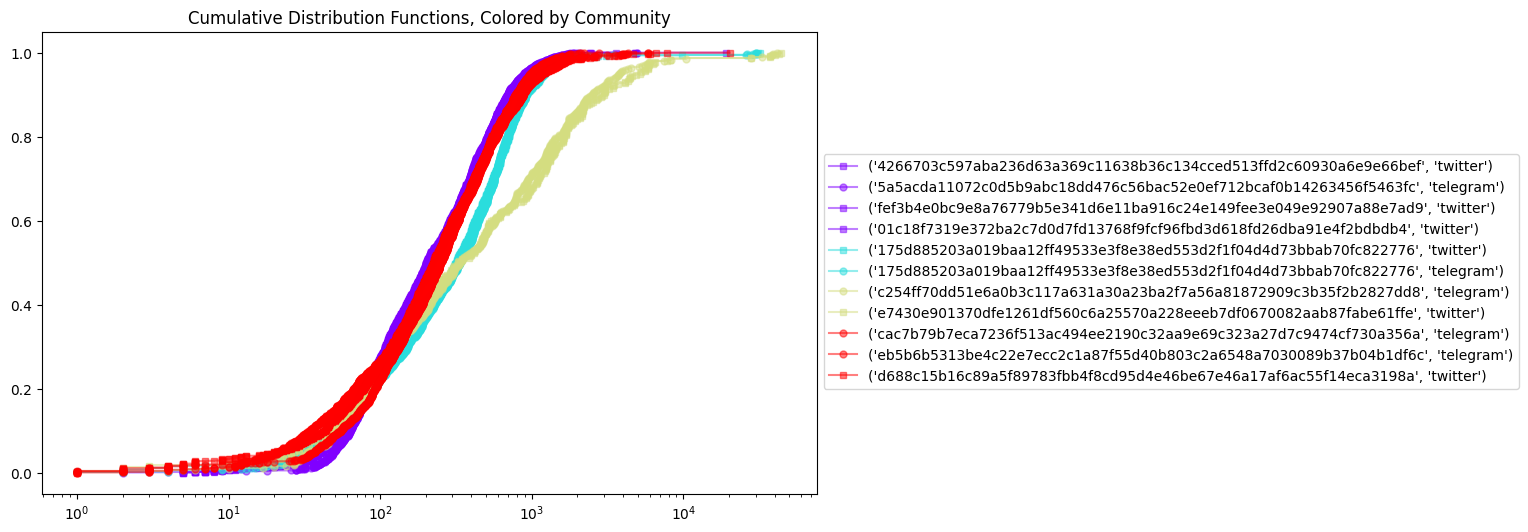

In [59]:
# Define shape for each platform
PLATFORM_SHAPES = {
    'telegram': 'o',  # circle
    'twitter': 's',   # square
    'instagram': '^',  # triangle down
}

def get_hist_vals(data, bins):
    f1, ax1 = plt.subplots(1, 1, figsize=(10,3))
    n,b,p = ax1.hist(data, rwidth=0.3, align="left", bins=bins, log=True, density=True)
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    
    plt.close(f1)
    return b[0:-1], n

def plot_cdf_with_color(data, ax, color, label, marker = "*"):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax.step(sorted_data, cdf, color=color, marker=marker, markersize=5, alpha=0.5, label=label)
    ax.set_title("Cumulative Distribution Functions, Colored by Community")
    ax.legend(bbox_to_anchor=(1,0.75))
    
def plot_communities(*communities, activity_df: pd.DataFrame):

    # Generate a unique color for each component
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    
    fig1, ax1 = plt.subplots(1, 1, figsize=(10,6))
    
    for community, color in zip(communities, colors):
        for user in community:
            name, platform = user
            data = activity_df.loc[user]["silence_periods"]
            plot_cdf_with_color(data, ax1, label=user, marker=PLATFORM_SHAPES[platform], color=color)
    ax1.set_xscale("log")

plot_communities(*ks_communities, activity_df=grouped_df)

### Evaluation

Let's compare the clustering of our method to the ground truth.

It is important to note that due to the filtering of weak ties and edge-selection process of the louvain, it is very possible that some users in the raw dataset will not appear in any community. Therefore, in evaluating our results, we will only look at users that *do* appear in a community.

The schema of the ground truth dataset:
- creator_name (str): the encrypted name of the profile
- platform_type (str): the platform type to which the profile belongs
- label: the number that has been (arbitrarily) assigned to the community to which the profile belongs


As our accuracy metric, we use [Normalized Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html), which is a well-known standard metric for clustering tasks.

In [60]:
# Get the true communities of the 
true_communities = (
    # Filter out users that do not appear in any of our predicted communities
    posts_df[posts_df[[PROFILE_COL_NAME, PLATFORMS_COL_NAME]].apply(tuple, 1).isin(G_ks)]
    # Group users according to common label to create communities
    .groupby("label").apply(lambda group: set(zip(group[PROFILE_COL_NAME], group[PLATFORMS_COL_NAME]))).tolist()
)
true_communities

/var/folders/zc/b62gpf_j6_xfkbm72shby5gm0000gn/T/ipykernel_92877/553686330.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  posts_df[posts_df[[PROFILE_COL_NAME, PLATFORMS_COL_NAME]].apply(tuple, 1).isin(G_ks)]


[{('01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd26dba91e4f2bdbdb4',
   'twitter'),
  ('4266703c597aba236d63a369c11638b36c134cced513ffd2c60930a6e9e66bef',
   'twitter'),
  ('5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bcaf0b14263456f5463fc',
   'telegram'),
  ('fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3e049e92907a88e7ad9',
   'twitter')},
 {('d688c15b16c89a5f89783fbb4f8cd95d4e46be67e46a17af6ac55f14eca3198a',
   'twitter'),
  ('eb5b6b5313be4c22e7ecc2c1a87f55d40b803c2a6548a7030089b37b04b1df6c',
   'telegram')},
 {('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'telegram'),
  ('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'twitter')},
 {('cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a27d7c9474cf730a356a',
   'telegram')},
 {('c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a81872909c3b35f2b2827dd8',
   'telegram'),
  ('e7430e901370dfe1261df560c6a25570a228eeeb7df0670082aab87fabe61ffe',
   'twitter')}]

In [61]:
# Evaluate the accuracy of the predicted communities by computing the Normalized Mutual Information score 

from typing import Set

def vectorize_communities(communities: Iterable[Iterable[Tuple]]) -> List[int]:
        """
        Convert a list of communities into a vectorized form of: [1, 1, 2, 2, 3, 3, 3, ...]
        * Note: the labels assigned to communities here do not necessarily match the labels in the dataframe.
        """
        # Create a mapping of users to their respective communities
        user_to_community = {
            user: community_label 
            for community_label, community in enumerate(communities)
            for user in community
        }

        # Create a sorted list of users based on the keys of the dictionary
        sorted_users = sorted(user_to_community.keys())
        
        # Build the community vector in the order of sorted users
        return [user_to_community[user] for user in sorted_users]


def compute_nmi(predicted_communities: List[Set[Tuple[str, str]]], true_communities: List[Set[Tuple[str, str]]]) -> float:
    """Compute the Normalized Mutual Information score of two clusterings."""

    # Ensure the users in the predicted and true communities are the same
    assert {user for comm in predicted_communities for user in comm} == {user for comm in true_communities for user in comm}
    return normalized_mutual_info_score(vectorize_communities(true_communities), vectorize_communities(predicted_communities))
    
nmi = compute_nmi(predicted_communities=ks_communities, true_communities=true_communities)

print(f"KS NMI score: {nmi}")


KS NMI score: 0.9392562497042766


#### Benchmarking: Dynamic Time-Warping

A well-known measurement of similarity between two temporal sequences, [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) estimates how similar two sets of sequenctial data are by finding the least 'costly' match between them.

Here, we will compute the DTW distances between 'time_from_start' vectors and check whether it identifies the communities the KS has identified.

Similarly to KS distance, the higher the DTW, the worse. So, we will again use the reciprocals of the DTW distance as the edges weights.


In [62]:
from tslearn.metrics import dtw

users_in_ks_communities = list(G_ks.nodes)

dtw_results = []

# compare every pair of users, skipping symmetrical and self comparisons
for i in range(len(users_in_ks_communities)):
    for j in range(i+1, len(users_in_ks_communities)):
        user1 = users_in_ks_communities[i]
        user2 = users_in_ks_communities[j]
        sp1 = grouped_df.loc[user1].time_from_start
        sp2 = grouped_df.loc[user2].time_from_start

        dtw_score = dtw(sp1, sp2)
        dtw_weight = 1 / dtw_score
        dtw_results.append((*user1, *user2, dtw_weight))

dtw_results = pd.DataFrame(
    dtw_results,
    columns=[
        PROFILE_COL_NAME + "_1", PLATFORMS_COL_NAME + "_1",
        PROFILE_COL_NAME + "_2", PLATFORMS_COL_NAME + "_2",
        "dtw",
    ]
)

dtw_results.head()

,creator_name_1,platform_type_1,creator_name_2,platform_type_2,dtw
0,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,4266703c597aba236d63a369c11638b36c134cced513ff...,twitter,0.000276
1,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bca...,telegram,0.000189
2,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3...,twitter,0.000022
3,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,telegram,0.000004
4,01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618f...,twitter,175d885203a019baa12ff49533e3f8e38ed553d2f1f04d...,twitter,0.000004


In [63]:
G_dtw = create_graph_from_data(dtw_results, "dtw")
communities_dtw = nx.community.louvain_communities(G_dtw)
communities_dtw

[{('01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd26dba91e4f2bdbdb4',
   'twitter'),
  ('4266703c597aba236d63a369c11638b36c134cced513ffd2c60930a6e9e66bef',
   'twitter'),
  ('5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bcaf0b14263456f5463fc',
   'telegram')},
 {('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'telegram'),
  ('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'twitter'),
  ('c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a81872909c3b35f2b2827dd8',
   'telegram'),
  ('e7430e901370dfe1261df560c6a25570a228eeeb7df0670082aab87fabe61ffe',
   'twitter')},
 {('cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a27d7c9474cf730a356a',
   'telegram'),
  ('d688c15b16c89a5f89783fbb4f8cd95d4e46be67e46a17af6ac55f14eca3198a',
   'twitter'),
  ('eb5b6b5313be4c22e7ecc2c1a87f55d40b803c2a6548a7030089b37b04b1df6c',
   'telegram'),
  ('fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3e049e92907a88e7ad9',
   'twitter')}]

In [64]:
nmi_dtw = compute_nmi(predicted_communities=communities_dtw, true_communities=true_communities)

print(f"DTW NMI score: {nmi_dtw}")


DTW NMI score: 0.6797030924073701


#### Posting Time Similarity

The approach we've presented makes the hypothesis that community members will have similar inter-event time distributions.

Another approach would look at the posting times themselves (as opposed to the inter-event times) and evaluate the degree to which two users post at or around the same time consistently. In this approach, we will define 'similarity' as the degree to which two users post within the same 5-minute time bins.

In [65]:
from typing import List, Set
from datetime import datetime, timedelta

def identity_matching(u: Set, v: Set) -> float:
    return min(len(u.intersection(v)) / len(u), len(u.intersection(v)) / len(v))

def compute_posting_time_similarities(bin_size: str):
    datetime_format = '%Y.%m.%d'
    min_date, max_date = [
        f([f(user['creation_times'])
        for _, user in grouped_df.iterrows()]).strftime(datetime_format)
        for f in (min, max)
    ]

    if min_date == max_date:
        max_date = (datetime.strptime(max_date, datetime_format) + timedelta(days=1)).strftime(datetime_format)

    # Break the date range into time bins
    TIME_BINS = pd.date_range(min_date, max_date, freq=bin_size)

    def timestamps_to_bins(timestamps: List[datetime], bins: List[datetime]) -> Set[datetime]:
        """linear search cause I'm lazy"""
        result = set()
        timestamps = sorted(timestamps)
        p_ts = p_bin = 0
        
        while p_ts < len(timestamps) and p_bin < len(bins) - 1:
            b1, b2 = bins[p_bin], bins[p_bin + 1]
            if b1 <= timestamps[p_ts] < b2:
                result.add(b1)
                p_ts += 1
                p_bin += 1
            elif b1 <= timestamps[p_ts]:
                p_bin += 1
            else:
                p_ts += 1

        return result

    filtered_users = grouped_df[grouped_df.index.isin(G_ks.nodes)]
    posting_time_similarities = set()

    timestamps_to_bins_mapping = {
        user: timestamps_to_bins(timestamps=filtered_users.loc[user]['creation_times'], bins=TIME_BINS)
        for user in filtered_users.index
    }

    for i in range(len(filtered_users)-1):
        for j in range(i+1, len(filtered_users)):
            a, b = pair = (filtered_users.index[i], filtered_users.index[j])
            u, v = [timestamps_to_bins_mapping[user] for user in pair]
            if len(u) == 0 or len(v) == 0:
                continue
            p = identity_matching(u, v)
            posting_time_similarities.add((a, b, p))
    
    return posting_time_similarities

G_activity_overlap = nx.Graph()
G_activity_overlap.add_weighted_edges_from(compute_posting_time_similarities('5min'))
activity_overlap_communities = nx.community.louvain_communities(G_activity_overlap)
activity_overlap_communities

[{('01c18f7319e372ba2c7d0d7fd13768f9fcf96fbd3d618fd26dba91e4f2bdbdb4',
   'twitter'),
  ('4266703c597aba236d63a369c11638b36c134cced513ffd2c60930a6e9e66bef',
   'twitter'),
  ('5a5acda11072c0d5b9abc18dd476c56bac52e0ef712bcaf0b14263456f5463fc',
   'telegram'),
  ('cac7b79b7eca7236f513ac494ee2190c32aa9e69c323a27d7c9474cf730a356a',
   'telegram'),
  ('d688c15b16c89a5f89783fbb4f8cd95d4e46be67e46a17af6ac55f14eca3198a',
   'twitter'),
  ('eb5b6b5313be4c22e7ecc2c1a87f55d40b803c2a6548a7030089b37b04b1df6c',
   'telegram'),
  ('fef3b4e0bc9e8a76779b5e341d6e11ba916c24e149fee3e049e92907a88e7ad9',
   'twitter')},
 {('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'telegram'),
  ('175d885203a019baa12ff49533e3f8e38ed553d2f1f04d4d73bbab70fc822776',
   'twitter'),
  ('c254ff70dd51e6a0b3c117a631a30a23ba2f7a56a81872909c3b35f2b2827dd8',
   'telegram'),
  ('e7430e901370dfe1261df560c6a25570a228eeeb7df0670082aab87fabe61ffe',
   'twitter')}]

In [66]:
nmi_activity_overlap = compute_nmi(predicted_communities=activity_overlap_communities, true_communities=true_communities)
print(f"Activity Overlap NMI score: {nmi_activity_overlap}")

Activity Overlap NMI score: 0.6037996275091858
